Kaggle Competition: Instacart Recommender
-----------------------------------------------

In this notebook I'll come up with a model for the [Instacart Kaggle Competition](https://www.kaggle.com/c/instacart-market-basket-analysis). The goal is to predict which product a user is going to order again the next time they place an order, based on their prior orders.

## A simple statistical model

I'll start with a very simple model based on two observations:

 1. some products are reordered more often than others;
 2. a given user orders some products more often than others.

To see this, let's have a look at these probabilities. We need to start by importing two files: 
 - `orders.csv` contains all the orders in the data set, both the prior orders to base our predictions on and the training and test sets.
 - `order_products__prior.csv` contains the products that were included in each of the orders in the prior set.

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings; warnings.simplefilter('ignore')

In [75]:
# Data about all the orders apart from which
# products they contain
orders = pd.read_csv('input/orders.csv')

# The set of prior orders we want to use to
# predict the next order a user is going to place
orders_prior = orders[orders['eval_set'] == 'prior']

# Add the product information to the prior orders
products_prior = pd.read_csv('input/order_products__prior.csv')
products_prior = products_prior.merge(
    orders_prior, 
    how = 'left', 
    on = 'order_id'
)

products_prior.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0


We now have a dataframe containing for each order a set of rows, one for each product. For each product, we have some additional information: the order in which it was placed into the cart by the user, and whether the user had ordered this product before (`reordered`).

We'll use this information to calculate two things. First, the overall reorder probability of all the products, which we'll call the prior probability (in the Bayesian sense) that a product is going to be reordered:

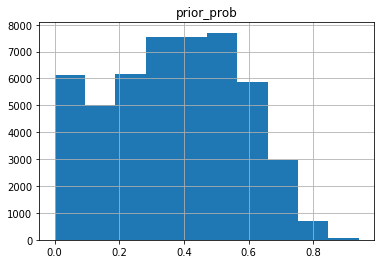

In [9]:
# We calculate the overall percentage of reorders for
# each product
product_prior_dist = pd.DataFrame(
    # Number of times product was reordered
    products_prior.groupby('product_id')['reordered'].sum()
    /
    # Total number of times product was ordered
    products_prior.groupby('product_id').size()
)

# Rename the column
product_prior_dist.columns = ['prior_prob']

# Most products are reordered between 0 and 50%
# of the time, with a tail of higher percentages
product_prior_dist.hist()
plt.show()

The histogram above shows that there is quite some spread in the reorder probabilities for different products. Taking this information into account should already be of some help.

Next we also want to incorporate the user's behavior. The prior probability serves as our base guess if we don't know anything about a user, but we can incorporate some evidence (in the Bayesian sense) because we know the user's order history.

Unfortunately, calculating the actual Bayesian likelihood of the evidence is not something we can do because we don't have a statistical model for what we expect a user to do. We could try to build such a model, but for now we'll take a heuristic approach. 

First we simply calculate the probability that a given user orders a given product. Then we want to modify the prior probability based on this user-dependent information. If the user orders a product more than 50% of the time, we want to increase our prior probability, and vice versa. We can do this for example by using

$$ p(u,i) = P(i) \frac{P(i|u)}{1-P(i|u)},  $$

where $P(i)$ is the overall (prior) probability of product $i$ (for item) being reordered, $P(i|u)$ is the probability of product $i$ being reordered by user $u$, and $p(u,i)$ is a score indicating how likely we think it is that product $i$ is going to be included in the user's next order.

Note that $p(u,i)$ is not a probability: its value can range from 0 to $\infty$. It's simply a number that satisfies our requirement: it's larger than $P(i)$ if $P(i|u) > 0.5$, and it's smaller than $P(i)$ if $P(i|u) < 0.5$.

The model we build with this parameter is very simple: we apply a threshold on $p(u,i)$ to predict whether or not the item is going to be reordered. We'll start with a naive threshold of 0.5, but there is no reason to assume that this makes sense, since our parameter is not a probability.

In [16]:
# For all users, for every product they've ordered,
# count how many times they've ordered it
products_ordered = (
    products_prior
    .groupby(['user_id', 'product_id'])
    .size()
    .reset_index()
    .rename(columns={0:'times_ordered'})
)

# For all users, count their number of orders
number_of_orders = pd.DataFrame(
    products_prior
    .groupby(['user_id'])['order_id']
    .nunique()
).reset_index().rename(columns={'order_id':'total_user_orders'})

# Merge
product_dist_per_user = products_ordered.merge(
    number_of_orders, 
    how = 'left', 
    on = 'user_id'
)

# Get product ordering probability per user
product_dist_per_user['product_prob_user'] = (
    product_dist_per_user['times_ordered']
    /product_dist_per_user['total_user_orders']
)

# Add in the overall ordering probabilities
product_prob = product_dist_per_user.merge(
    product_prior_dist, 
    how = 'left', 
    left_on = 'product_id', 
    right_index = True)

# Calculate reordering score p
product_prob['p'] = (
    product_prob['product_prob_user']
    *product_prob['prior_prob']
    /(1-product_prob['product_prob_user'])
)

product_prob.head(3)

,user_id,product_id,times_ordered,total_user_orders,product_prob_user,prior_prob,p
0,1,196,10,10,1.0,0.776480,inf
1,1,10258,9,10,0.9,0.713772,6.423947
2,1,10326,1,10,0.1,0.652009,0.072445


We've calculated our parameter for each product in every user's prior history. Now let's grab the training set and make our predictions. First we need to build our training data from `orders.csv` and `order_products__train.csv`.

In [10]:
# Get the orders in the training set for which
# we need predictions
orders_train = orders[orders['eval_set'] == 'train']

# Import the products and add to the data
products_train = pd.read_csv('input/order_products__train.csv')
products_train = products_train.merge(
    orders_train, 
    how = 'left', 
    on = 'order_id')

# We only need to predict reordered products, not
# products that are ordered for the first time
products_train = products_train[products_train['reordered']==1]
products_train.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [13]:
# We don't want a row for every product, but one
# row per order with a list of the reordered products
reordered_train = products_train[['order_id', 'product_id']].groupby('order_id')['product_id'].apply(list)

# Put the user_id of the orders back in; we'll need it
# to get the user-dependent ordering probabilities
reordered_train = pd.DataFrame(reordered_train).merge(
    orders_train[['order_id','user_id']], 
    how = 'left', 
    right_on = 'order_id', 
    left_index = True
)

reordered_train.head(3)

,product_id,order_id,user_id
1868044,"[49302, 11109, 43633, 22035]",1,112108
1322255,"[19660, 43086, 46620, 34497, 48679, 46979]",36,79431
709772,[21616],38,42756


In [19]:
# Predict based on the reordering score which
# products a user is going to want in their
# next order. Note that the threshold of 0.5
# is unlikely to be optimal.
pred = product_prob[product_prob['p'] > 0.5]

# Convert to list format
pred = pred.groupby('user_id')['product_id'].apply(list)

# Combine truth and prediction
reordered_pred_train = reordered_train.merge(
    pd.DataFrame(pred), 
    how='left', 
    left_on='user_id', 
    right_index = True
)

# If we didn't predict any products will be reordered,
# we make this explicit as 'None'
reordered_pred_train.fillna('None', inplace=True)

reordered_pred_train.head(3)

,product_id_x,order_id,user_id,product_id_y
1868044,"[49302, 11109, 43633, 22035]",1,112108,"[5707, 11109, 14947, 22035, 30881, 43633, 4435..."
1322255,"[19660, 43086, 46620, 34497, 48679, 46979]",36,79431,"[19660, 20119]"
709772,[21616],38,42756,"[1940, 8012]"
284948,"[20574, 40706, 27966, 24489, 39275]",96,17227,"[20574, 29603]"
941403,"[8859, 19731, 43654, 13176, 4357, 37664, 34065...",98,56463,"[329, 4357, 8859, 9896, 13176, 15455, 19731, 2..."


Now that we have our predictions and truth values properly arranged, we can score our predictions. The competition uses the average [F1 score](https://en.wikipedia.org/wiki/F1_score), which is a metric that compares the number of true positives (we correctly predicted the user would buy a product) to both the number of false positives (we incorrectly thought the user would reorder a product) and the number of false negatives (we incorrectly thought the user would not reorder a product). We'll need some helper functions to calculate this score.

In [21]:
# Helper functions to calculate the F1 score
def precision(truth, pred):
    true_positives = set(truth).intersection(pred)
    false_positives = set(pred) - set(truth)
    num_true = len(true_positives)
    num_false = len(false_positives)
    if (num_true + num_false == 0):
        return 1
    else:
        return num_true/(num_true+num_false)
    
def recall(truth, pred):
    true_positives = set(truth).intersection(pred)
    false_negatives = set(truth) - set(pred)
    num_true = len(true_positives)
    num_false = len(false_negatives)
    if (num_true + num_false == 0):
        return 1
    else:
        return num_true/(num_true+num_false)
    
def f1_score(truth, pred):
    p = precision(truth, pred)
    r = recall(truth, pred)
    if( p+r == 0 ):
        return 0
    else:
        return 2*p*r/(p+r)

Let's calculate the F1 scores for our predictions.

In [22]:
# Calculate the F1 scores of our predictions
reordered_pred_train['f1'] = reordered_pred_train.apply(
    lambda row: f1_score(row['product_id_x'], row['product_id_y']), 
    axis=1
)

# The average F1 score of our prediction
reordered_pred_train['f1'].mean()

0.30093237501166153

We get an F1 score on the training set of 0.30, which at time of writing is on the lower end of the Kaggle leaderboard. Not bad for a first try. Note that even though we calculated this score on the training set, we haven't actually fit it to the training data. We've only used information from the prior history.

There is only one parameter in our model, which is the classification threshold. We arbitarily selected 0.5 above, but there is no reason to assume that this would be optimal. We'll optimize the threshold on the training set (we should cross-validate, but we'll perform this simple optimization for now).

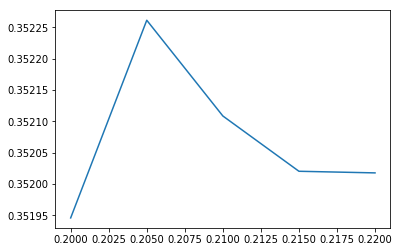

In [29]:
# Optimize the threshold value
thresholds = [0.2,0.205,0.21,0.215,0.22]
scores = []
for t in thresholds:
    pred = (
        product_prob[product_prob['p'] > t]
        .groupby('user_id')['product_id']
        .apply(list)
    )
    reordered_pred_train = reordered_train.merge(
        pd.DataFrame(pred), 
        how='left', 
        left_on='user_id', 
        right_index = True
    )
    reordered_pred_train.fillna('None', inplace=True)
    reordered_pred_train['f1'] = reordered_pred_train.apply(
        lambda row: f1_score(
            row['product_id_x'], 
            row['product_id_y']
        ), 
        axis=1)
    scores.append(reordered_pred_train['f1'].mean())
    
plt.plot(thresholds, scores)
plt.show()

We see that by optimizing the threshold to 0.205, we reach an F1 score on the training set of over 0.35.

Now let's use our optimized model to make a prediction on the test data.

In [23]:
# Redo our prediction with the optimal threshold
pred = product_prob[product_prob['p'] > 0.205].groupby('user_id')['product_id'].apply(list)

# Predict for the test set
pred_test = orders[orders['eval_set'] == 'test'].merge(
    pd.DataFrame(pred), 
    how='left', 
    left_on='user_id', 
    right_index = True
)

# Set empty predicitons explicitly to 'None'
pred_test.fillna('None', inplace=True)

# Convert list of products to string
pred_test['products'] = pred_test.apply(
    # 'None' values are not list; don't join them
    lambda x: (
        (' '.join(str(y) for y in x['product_id']) 
         if (x['product_id'] != 'None') 
         else 'None')
    )
    , axis=1
)

# Generate our submission and save to file
subm = pred_test[['order_id', 'products']].sort_values('order_id')
subm.to_csv('output/submission_v2.csv', index=False)

subm.head(3)

,order_id,products
611292,17,6291 13107 15613 21463 21709 21903 31964 38777...
584613,34,16083 21137 39180 39475 43504 47029 47766 47792
3102779,137,2326 5134 23794 24852 25890 29594 38689 41787 ...


This submission reached a score of 0.336 on the Kaggle leaderboard, a little lower than our score on the training data. It may be that we are somewhat overfitting the training set.

In any case, this simple model performs quite reasonably. It scores better than that of simple benchmarks (such as repeating a customer's last order), but of course not as well as the top scores (around 0.4 at time of writing).

## A boosted tree model

The data set of course contains more information than what we've used so far. For each order, we know for instance on what day of the week and what hour of the day it was ordered, and how many days it has been since the user's previous order. We'll use such information to build a more advanced model. We'll use `xgboost` to fit a model, using our previously calculated prior and user-dependent probabilities as features, along with some new ones.

In [26]:
# Add information about the training orders to our
# feature DataFrame
training_set = product_prob.merge(
    products_train, 
    how = 'left', 
    on = ['user_id', 'product_id']
)[[
    'order_id', 
    'user_id', 
    'product_id', 
    'prior_prob', 
    'product_prob_user', 
    'order_dow', 
    'order_hour_of_day', 
    'days_since_prior_order'
]]

# The dataframe contains all products a user previously
# ordered, but only some of those are part of a training
# order. We can use this to create a boolean column
# indicating whether or not a product was reordered.
training_set['reordered'] = ~pd.isnull(training_set['order_id'])

# Products that were not reordered do not have the
# order properties like day-of-week set, so let's add
# them

# Day of week
training_set = training_set.merge(
    pd.DataFrame(
        training_set
        .groupby('user_id')['order_dow']
        .mean()
    ).rename(columns = {'order_dow': 'dow'}), 
    how = 'left', 
    left_on = 'user_id', 
    right_index = True
)

# Hour of day
training_set = training_set.merge(
    pd.DataFrame(
        training_set
        .groupby('user_id')['order_hour_of_day']
        .mean()
    ).rename(columns = {'order_hour_of_day': 'hour_of_day'}), 
    how = 'left', 
    left_on = 'user_id', 
    right_index = True
)

# Days since previous order
training_set = training_set.merge(
    pd.DataFrame(
        training_set
        .groupby('user_id')['days_since_prior_order']
        .mean()
    ).rename(columns = {'days_since_prior_order': 'days_since_prev'}), 
    how = 'left', 
    left_on = 'user_id', 
    right_index = True
)

# Order ID
training_set = training_set.merge(
    pd.DataFrame(
        training_set
        .groupby('user_id')['order_id']
        .mean()
    ).rename(columns = {'order_id': 'order_id_fillna'}), 
    how = 'left', 
    left_on = 'user_id', 
    right_index = True
)

# For the procedures above, we had to rename the columns. We now
# get rid of the old columns
training_set['order_id'] = training_set['order_id_fillna']
training_set = training_set.drop(
    [
        'order_dow', 
        'order_hour_of_day', 
        'days_since_prior_order', 
        'order_id_fillna'
    ], 
    axis = 1
)

# Predictions that still don't have order properties
# are not part of the training set
training_set = training_set.dropna(subset=['dow'])
training_set.head(5)

,order_id,user_id,product_id,prior_prob,product_prob_user,reordered,dow,hour_of_day,days_since_prev
0,1187899.0,1,196,0.776480,1.0,True,4.0,8.0,14.0
1,1187899.0,1,10258,0.713772,0.9,True,4.0,8.0,14.0
2,1187899.0,1,10326,0.652009,0.1,False,4.0,8.0,14.0
3,1187899.0,1,12427,0.740735,1.0,False,4.0,8.0,14.0
4,1187899.0,1,13032,0.657158,0.3,True,4.0,8.0,14.0


Let's also incorporate some further information that's part of the dataset. For example, there is a table `products.csv` which tells us which aisle a product belongs to, aisles being categories like "fresh pasta" and "vitamins and supplements". The aisle a product is in may provide some more information about how likely a product is to be reordered.

To take full advantage of this information, it might be best to one-hot encode the aisles, but this will create a large number of features. To keep it simple, let's instead take a statistical approach as in the beginning: for each aisle, we will calculate the reorder probability, and use that as a feature.

In [24]:
# Import aisle information
products = pd.read_csv('input/products.csv')[['product_id', 'aisle_id']]

# Add the aisle IDs to our products
products_aisle = products_prior.merge(products, how='left', on = 'product_id')

# We calculate the overall percentage of reorders for
# each aisle
product_prior_aisle = pd.DataFrame(
    # Number of times products from aisle were reordered
    products_aisle.groupby('aisle_id')['reordered'].sum()
    /
    # Total number of orders from aisle
    products_aisle.groupby('aisle_id').size()
)

# Rename the column
product_prior_aisle.columns = ['aisle_prob']

product_prior_aisle.head(3)

,aisle_prob
aisle_id,
1,0.596597
2,0.489326
3,0.598007


In [27]:
# Add the aisle probabilities to our training set
training_set_with_aisle = training_set.merge(
    products, 
    how='left', 
    on = 'product_id'
).merge(
    product_prior_aisle, 
    how = 'left', 
    left_on = 'aisle_id', 
    right_index = True
)

training_set_with_aisle.head(3)

,order_id,user_id,product_id,prior_prob,product_prob_user,reordered,dow,hour_of_day,days_since_prev,aisle_id,aisle_prob
0,1187899.0,1,196,0.776480,1.0,True,4.0,8.0,14.0,77,0.638832
1,1187899.0,1,10258,0.713772,0.9,True,4.0,8.0,14.0,117,0.519170
2,1187899.0,1,10326,0.652009,0.1,False,4.0,8.0,14.0,24,0.718104


Now we're ready to start training a model on our training data. Our features are the three reorder probabilities we calculated (per product, per product per user and per aisle) and three properties of the orders (day of week, hour of day and days since previous order). The target is whether a product is contained in the new order or not.

In [28]:
# Generate training and validation sets for our
# xgboost model
X_train, X_val, y_train, y_val = train_test_split(
    training_set_with_aisle[[
        'prior_prob', 
        'product_prob_user', 
        'aisle_prob', 
        'dow', 
        'hour_of_day', 
        'days_since_prev'
    ]], 
    training_set_with_aisle[[
        'reordered'
    ]],
    test_size = 0.25,
)

# Transforming our data into XGBoost's internal DMatrix structure
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_val, y_val)

# Setting up initial parameters for our model
xgb_params = {
    "objective": "binary:logistic", 
    "eval_metric": "logloss",
    "max_depth": 6, 
    "silent": 0, 
    'eta': 0.1,
    "min_child_weight": 10
}

# Maximum number of trees we will collect
num_rounds = 5000

# Training
model = xgb.train(
    xgb_params,                           # Training parameters
    dtrain,                               # Data
    num_rounds,                           # Max number of trees
    [(dtrain,'train'),(dvalid,'test')],   # Validation set
    early_stopping_rounds = 50,           # Stop early if no improvement for 50 rounds
    verbose_eval = 100
)

[0]	train-logloss:0.627568	test-logloss:0.627601
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.268206	test-logloss:0.268807
[200]	train-logloss:0.26756	test-logloss:0.268459
[300]	train-logloss:0.267133	test-logloss:0.26832
[400]	train-logloss:0.266792	test-logloss:0.268266
[500]	train-logloss:0.266469	test-logloss:0.268231
Stopping. Best iteration:
[516]	train-logloss:0.266425	test-logloss:0.268229



Our new model predicts probabilities for the two classes, and we still have a treshold to choose for our actual classification. Since we now do have probabilities, we might expect that a threshold of 0.5 is appropriate. However, note that to train our model we used the log-loss metric, not the F1 score. The F1 score is expensive to calculate, slowing down the training, and it is also a discrete metric in the sense that it only changes value when our classification of a product changes from True to False or vice versa. This makes it difficult to train with.

Therefore, we have instead used the continuous log-loss metric. This does of course pursue the same goal as the F1 metric - improving classification accuracy - but optimizing log-loss does not necessarily optimize the F1 score. However, we will make do and try to adjust as best we can by optimizing our classification threshold.

In [30]:
# Let's see how we do with a naive 0.5 threshold

# Predict on the training set
training_set_with_aisle['xgb_pred'] =  model.predict(
    xgb.DMatrix(
        training_set_with_aisle[[
            'prior_prob', 
            'product_prob_user', 
            'aisle_prob', 
            'dow', 
            'hour_of_day', 
            'days_since_prev'
        ]]
    )
) > 0.5

# Build lists of predicted products
xgb_pred_groups = training_set_with_aisle[
    training_set_with_aisle['xgb_pred']
].groupby('order_id')['product_id'].apply(list)

# Combine with our truth values
xgb_pred_train = reordered_train.merge(
    pd.DataFrame(xgb_pred_groups), 
    how='left', 
    left_on='order_id', 
    right_index = True
)

# Fill in empty values
xgb_pred_train.fillna('None', inplace=True)

# Calculate F1 scores per order and overall
xgb_pred_train['f1'] = xgb_pred_train.apply(
    lambda row: f1_score(
        row['product_id_x'],
        row['product_id_y']
    ),
    axis=1
)
xgb_pred_train['f1'].mean()

0.17285288449631486

With a threshold of 0.5, our model doesn't perform very well. We don't expect it to do worse than our simple model, so there must be a better value for the threshold.

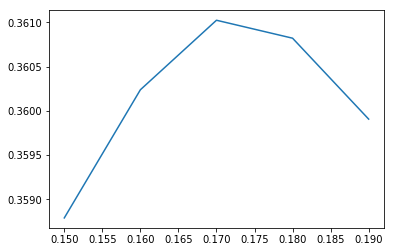

In [31]:
# Optimize the threshold value
thresholds = [0.15,0.16,0.17,0.18,0.19]
scores = []
for t in thresholds:
    training_set_with_aisle['xgb_pred'] =  model.predict(
        xgb.DMatrix(
            training_set_with_aisle[[
                'prior_prob', 
                'product_prob_user', 
                'aisle_prob', 'dow', 
                'hour_of_day', 
                'days_since_prev'
            ]]
        )
    ) > t
    xgb_pred_groups = (
        training_set_with_aisle[training_set_with_aisle['xgb_pred']]
        .groupby('order_id')['product_id']
        .apply(list)
    )
    xgb_pred_train = reordered_train.merge(
        pd.DataFrame(xgb_pred_groups), 
        how='left', 
        left_on='order_id', 
        right_index = True
    )
    xgb_pred_train.fillna('None', inplace=True)
    xgb_pred_train['f1'] = xgb_pred_train.apply(
        lambda row: f1_score(row['product_id_x'], row['product_id_y']), 
        axis=1
    )
    scores.append(xgb_pred_train['f1'].mean())
    
plt.plot(thresholds, scores)
plt.show()

We see that our score is much improved by going to a threshold of 0.17 instead of 0.5. Our new model scores quite a bit better on our training data. Let's generate the prediction for our test data.

In [32]:
# Merge the orders in the test set into our
# feature dataframe
testing_set = product_prob.merge(
    orders[orders['eval_set'] == 'test'], 
    how = 'left', 
    on = ['user_id']
)[[
    'order_id', 
    'user_id', 
    'product_id', 
    'prior_prob', 
    'product_prob_user', 
    'order_dow', 
    'order_hour_of_day', 
    'days_since_prior_order'
]]

# Drop rows that don't correspond to the
# test set
testing_set = testing_set.dropna()

# Add our aisle feature
testing_set = testing_set.merge(
    products, 
    how='left', 
    on = 'product_id'
).merge(
    product_prior_aisle, 
    how = 'left', 
    left_on = 'aisle_id', 
    right_index = True
)

# Rename columns to match training set
testing_set = testing_set.rename(
    columns={
        'order_dow': 'dow', 
        'order_hour_of_day': 'hour_of_day', 
        'days_since_prior_order': 'days_since_prev'
    }
)

# Predict using our optimized threshold value
testing_set['xgb_pred'] = model.predict(
    xgb.DMatrix(
        testing_set[[
            'prior_prob', 
            'product_prob_user', 
            'aisle_prob', 
            'dow', 
            'hour_of_day', 
            'days_since_prev'
        ]]
    )
) > 0.17

# Generate lists. (Method slightly changed because
# we now have empty predictions)
xgb_pred_groups_test = (
    testing_set
    .groupby('order_id')
    .apply(lambda g: list(g[g['xgb_pred']]['product_id']))
)

# Convert to dataframe
xgb_subm = pd.DataFrame(xgb_pred_groups_test).reset_index()

# Replace empty lists with explicit ['None']
xgb_subm[0] = xgb_subm[0].apply(
    lambda x: ['None'] if len(x)==0 else x
)

# Convert list of products to string
xgb_subm['products'] = xgb_subm.apply(
    lambda x: ' '.join(str(y) for y in x[0])
    , axis=1
)

# Generate our submission and save to file
(
    xgb_subm[['order_id', 'products']]
    .sort_values('order_id')
    .to_csv(
        'output/submission_v6.csv', 
        index=False, 
        float_format='%.f'
    )
)

xgb_subm[['order_id', 'products']].head(3)

,order_id,0,products
0,17.0,"[13107, 21463, 21709, 38777, 47766]",13107 21463 21709 38777 47766
1,34.0,"[16083, 21137, 39180, 39475, 43504, 47029, 477...",16083 21137 39180 39475 43504 47029 47766 47792
2,137.0,"[2326, 5134, 23794, 24852, 25890, 38689, 41787...",2326 5134 23794 24852 25890 38689 41787 43352


This submission scored 0.343 on the leaderboard, again a bit lower than on our training data. We've certainly not reached the full potential of the data, but we've tapped into some of its predictive power.

## Adding temporal information

How could we improve our model further? We haven't optimized the hyperparameters of our `xgboost` model, besides some manual fiddling, so our model itself may not be optimal. However, more importantly, the data set contains a lot of further information that we've left untapped here, and which we might want to include. 

Primarily, we've treated users' history of orders as one bulk of ordering behavior, neglecting the fact that they may have different orders at different points in time. For instance, we predict high probability of a user reordering a product if they've ordered it many times before. But perhaps those many orders are early in their history, while lately they haven't bought that product anymore. Another example is that if we know that a user buys a product in 1 out of every 5 orders, it might make more sense to give high probability for reordering after the user hasn't ordered it the last 4 times, rather than just giving every order a 1/5 probability of including that order.

There are various ways in which we could look at the history as a time-dependent dataset. We might consider viewing the data as a set of time series, but it's easier to try to extract some time data in the form of features that we can feed to our boosted tree model. To capture potential changes in time, we for now simply include the order number (a counter that equals 1 for a user's first ever order, and then counts up from there). To capture the second effect we mentioned, we include the number of orders since a user last ordered a product.

In [74]:
# Let's construct our feature. To find out how
# long it has been since a user ordered a product,
# we need to know...
products_ordered_last = pd.DataFrame(
    # ...from the prior history...
    products_prior
    # ...the numbers of the orders per user in which
    # a given product appears...
    .groupby(['user_id', 'product_id'])['order_number']
    # ...and of those the latest one...
    .max()
).reset_index().merge(
    # ...as well as the user's total number of orders
    number_of_orders, 
    how = 'left', 
    on = 'user_id'
)

# The number of orders since the last time the product
# was ordered is the difference of the two
products_ordered_last['orders_since_last'] = pd.DataFrame(
    products_ordered_last['total_user_orders'] 
    - 
    products_ordered_last['order_number']
)

products_ordered_last.head(3)

,user_id,product_id,order_number,total_user_orders,orders_since_last
0,1,196,10,10,0
1,1,10258,10,10,0
2,1,10326,5,10,5


In [62]:
# Add the new feature to our training set
new_training_set = training_set_with_aisle.merge(
    products_ordered_last[[
        'user_id',
        'product_id',
        'orders_since_last'
    ]],
    how = 'left',
    on = ['user_id', 'product_id']
).merge(
    # As well as the order number
    orders[['order_id','order_number']],
    how = 'left',
    on = 'order_id'
)

# And train a new model

# Generate training and validation sets for our
# xgboost model
X_train, X_val, y_train, y_val = train_test_split(
    new_training_set[[
        'prior_prob', 
        'product_prob_user', 
        'aisle_prob', 
        'dow', 
        'hour_of_day', 
        'days_since_prev',
        'orders_since_last',
        'order_number'
    ]], 
    new_training_set[[
        'reordered'
    ]],
    test_size = 0.25,
)

# Transforming our data into XGBoost's internal DMatrix structure
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_val, y_val)

# Setting up initial parameters for our model
xgb_params = {
    "objective": "binary:logistic", 
    "eval_metric": "logloss",
    "max_depth": 6, 
    "silent": 0, 
    'eta': 0.1,
    "min_child_weight": 10
}

# Maximum number of trees we will collect
num_rounds = 5000

# Training
model = xgb.train(
    xgb_params,                           # Training parameters
    dtrain,                               # Data
    num_rounds,                           # Max number of trees
    [(dtrain,'train'),(dvalid,'test')],   # Validation set
    early_stopping_rounds = 50,           # Stop early if no improvement for 50 rounds
    verbose_eval = 100
)

[0]	train-logloss:0.626522	test-logloss:0.626524
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.251991	test-logloss:0.252512
[200]	train-logloss:0.251207	test-logloss:0.252047
[300]	train-logloss:0.25068	test-logloss:0.251829
[400]	train-logloss:0.250229	test-logloss:0.251704
[500]	train-logloss:0.249817	test-logloss:0.251611
[600]	train-logloss:0.249459	test-logloss:0.251553
[700]	train-logloss:0.249138	test-logloss:0.251514
[800]	train-logloss:0.248815	test-logloss:0.25148
[900]	train-logloss:0.248502	test-logloss:0.251453
[1000]	train-logloss:0.248208	test-logloss:0.251436
Stopping. Best iteration:
[996]	train-logloss:0.248218	test-logloss:0.251435



We see that the log-loss during training is improved by adding these new features. They turn out to be quite important features, ranking fourth and fifth by F-score:

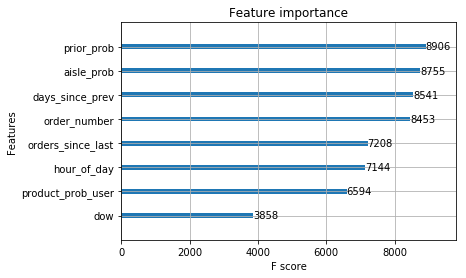

In [63]:
xgb.plot_importance(model);
plt.show()

Now we can optimize our classification threshold and then add this feature to our test data as well, and generate a new prediction. 

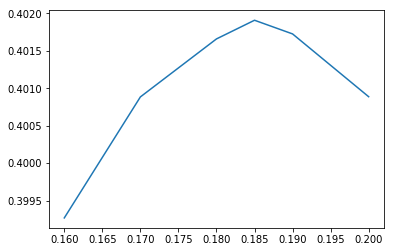

In [65]:
# Optimize the threshold value
thresholds = [0.16,0.17,0.18,0.185,0.19, 0.2]
scores = []
for t in thresholds:
    new_training_set['xgb_pred'] =  model.predict(
        xgb.DMatrix(
            new_training_set[[
                'prior_prob', 
                'product_prob_user', 
                'aisle_prob', 'dow', 
                'hour_of_day', 
                'days_since_prev',
                'orders_since_last',
                'order_number'
            ]]
        )
    ) > t
    xgb_pred_groups = (
        new_training_set[new_training_set['xgb_pred']]
        .groupby('order_id')['product_id']
        .apply(list)
    )
    xgb_pred_train = reordered_train.merge(
        pd.DataFrame(xgb_pred_groups), 
        how='left', 
        left_on='order_id', 
        right_index = True
    )
    xgb_pred_train.fillna('None', inplace=True)
    xgb_pred_train['f1'] = xgb_pred_train.apply(
        lambda row: f1_score(row['product_id_x'], row['product_id_y']), 
        axis=1
    )
    scores.append(xgb_pred_train['f1'].mean())
    
plt.plot(thresholds, scores)
plt.show()

The optimal threshold value has shifted a little bit, but more importantly, the score has improved substantially to over 0.4! Of course this is the training error; we will have to see how well we do on the test data.

In [71]:
# Add our new features to the testing data
new_testing_set = testing_set.merge(
    products_ordered_last[[
        'user_id',
        'product_id',
        'orders_since_last'
    ]],
    how = 'left',
    on = ['user_id', 'product_id']
).merge(
    # As well as the order number
    orders[['order_id','order_number']],
    how = 'left',
    on = 'order_id'
)

# Predict using our optimized threshold value
new_testing_set['xgb_pred'] = model.predict(
    xgb.DMatrix(
        new_testing_set[[
            'prior_prob', 
            'product_prob_user', 
            'aisle_prob', 
            'dow', 
            'hour_of_day', 
            'days_since_prev',
            'orders_since_last',
            'order_number'
        ]]
    )
) > 0.185

# Generate lists.
xgb_pred_groups_test = (
    new_testing_set
    .groupby('order_id')
    .apply(lambda g: list(g[g['xgb_pred']]['product_id']))
)

# Convert to dataframe
xgb_subm = pd.DataFrame(xgb_pred_groups_test).reset_index()

# Replace empty lists with explicit ['None']
xgb_subm[0] = xgb_subm[0].apply(
    lambda x: ['None'] if len(x)==0 else x
)

# Convert list of products to string
xgb_subm['products'] = xgb_subm.apply(
    lambda x: ' '.join(str(y) for y in x[0])
    , axis=1
)

# Generate our submission and save to file
(
    xgb_subm[['order_id', 'products']]
    .sort_values('order_id')
    .to_csv(
        'output/submission_v8.csv', 
        index=False, 
        float_format='%.f'
    )
)

The new time-based features turn out to be a very important addition: the score on the leaderboard has shot up to 0.378!

## Where to go from here

We have gotten a lot closer to the top scores on the current leaderboard, but we've obviously still not captured all the information that's in the data, or fully optimized our model. We should optimize the hyperparameters of our boosted tree model. We should also select our classification threshold based on cross validation rather than just using the training error.

There are also further components to the data: besides the aisles, products are further organized into departments. Also, instead of calculating a reordering probability for these categories, we could one-hot encode them to give the model full access.

More temporal information could potentially be extracted. For example, we considered the situation where a user buys a product every n-th order. But perhaps the periodicity is not so simple. Perhaps they order a product only on two consecutive days every week, whereas on all other days they make an order but don't order this product. Their ordering probability is then 2/7, and we might incorrectly think they want to reorder after 3-4 days, which would give consistently wrong predictions. Such more complicated features of time-dependent behavior could contain valuable information.

All in all, the Instacart dataset is quite rich, and it will be interesting to see what kind of models eventually take home the cake!